In [1]:
# ! pip install pip install PyPortfolioOpt

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gmean
from pypfopt.hierarchical_portfolio import HRPOpt
from datetime import date
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random

## Data Handling

In [2]:
newdata = pd.read_csv('data/price_data.csv').dropna()
newdata.set_index('time',inplace=True)
newdata.reset_index(inplace=True)

#Format Dates by removing timestamps

newdata.rename(columns={'time':'Date', 'close':'Price'},inplace=True)
newdata['Date'] = pd.to_datetime(newdata['Date']).dt.date
newdata['Date'] = newdata['Date'].astype('datetime64[ns]')
# data.set_index("Date")


In [3]:
# symbols = data["symbol"].unique()
#
# list_of_df = list()

#Append Prices
# for symbol in symbols:
#     temp_df = pd.DataFrame()
#     temp_df = data[data['symbol'] == symbol]
#     temp_df = temp_df.drop(['symbol','Date'], axis=1)
#     temp_df = temp_df.rename(columns={'Price': symbol })
#     temp_df = temp_df.values.tolist()
#     list_of_df.append(temp_df)

#Append Date in list
# list_of_df.append(data['Date'].tolist())
#
# final_data = pd.DataFrame()
#
# for df in list_of_df:
#     final_data = pd.concat([final_data, df],axis=1)




In [4]:
pivot_df = newdata.pivot(index= "Date", columns='symbol', values='Price')
pivot_df.columns.name = None
pivot_df.reset_index(inplace=True)

In [5]:
#Averaging over timestamps in a day

# data = data.groupby('Date').mean()
# data.reset_index(inplace=True)


In [6]:
data=pivot_df
data.set_index("Date",inplace=True)


In [10]:
# Calculate log returns

log_returns = np.log(data).diff()
log_returns.reset_index(inplace=True)

In [69]:

# returns = []
#
# for i in range (0,len(data)):
#     if i == 0:
#         value = 0
#     else :
#         value = np.log(data[i]/data[i-1])
#     returns.append(value)
#
# data['Returns'] = returns


KeyError: 1

In [12]:
# Add columns for years and months

log_returns['Year'] = log_returns['Date'].dt.year
log_returns['Month'] = log_returns['Date'].dt.month

yr= sorted(log_returns.Year.unique())
mo= sorted(log_returns.Month.unique())



In [13]:
#Drop one data point causing trouble

# data.set_index(['Month','Year'],inplace=True)
# data.drop((1,2022),inplace=True)
# data.reset_index(inplace=True)

,Date,BTC,ETH,Year,Month
0,2019-01-02,NaN,NaN,2019,1
1,2019-01-03,-0.027422,-0.038881,2019,1
2,2019-01-04,0.005452,0.035872,2019,1
3,2019-01-05,-0.003252,0.006812,2019,1
4,2019-01-06,0.058447,0.013451,2019,1
...,...,...,...,...,...
1091,2021-12-28,-0.062151,-0.060401,2021,12
1092,2021-12-29,-0.024336,-0.046408,2021,12
1093,2021-12-30,0.015668,0.023242,2021,12
1094,2021-12-31,-0.018649,-0.008442,2021,12


In [14]:
#Create list of data frames for every month's data

df = []
for i in yr:
    for j in mo:
        d = log_returns[(log_returns['Month'] == j) & (log_returns['Year']==i)]
        if d.empty:
            continue
        else:
            df.append(d)

## Hierarchial Risk Parity (for entire data)

In [17]:
#HRP Model

new_data = log_returns.drop(columns=['Month','Year'])
new_data.set_index('Date', inplace=True)
HRP = HRPOpt(new_data,new_data.cov)

In [18]:
#Weights for Minimum Var Portfolio  using Hierarchial Risk Parity Algorithm
w_vector = HRP.optimize(linkage_method='single')
weights= w_vector.values()


In [19]:
#Model Performance for total number of days in dataset 

hrp_vol = HRP.portfolio_performance(weights)[1]*100
hrp_rtrn = HRP.portfolio_performance(weights)[0]*100


Expected annual return: 63.4%
Annual volatility: 65.8%
Sharpe Ratio: 0.93
Expected annual return: 63.4%
Annual volatility: 65.8%
Sharpe Ratio: 0.93


## Monthly HRP

In [34]:
hrp_list = []

for i in range(0,len(df)):

    dataset= df[i]
    month= dataset.Month.unique()[0]
    year= dataset.Year.unique()[0]
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataset= df[i].drop(columns=['Month','Year']).dropna()
    dataset.set_index('Date', inplace=True)

    HRP_m = HRPOpt(dataset,np.cov)
    w_vector_m = HRP_m.optimize()
    weights_m= w_vector_m.values()
    performance_m = HRP_m.portfolio_performance(risk_free_rate= 0.036)
    rtrn_m = performance_m[0]*100
    vol_m = performance_m[1]*100
    hrp_list.append([month,year,rtrn_m,vol_m])


C:\Users\Nilakshi Mondal\AppData\Local\Temp\ipykernel_36816\2515972399.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Nilakshi Mondal\AppData\Local\Temp\ipykernel_36816\2515972399.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Nilakshi Mondal\AppData\Local\Temp\ipykernel_36816\2515972399.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

ValueError: The condensed distance matrix must contain only finite values.

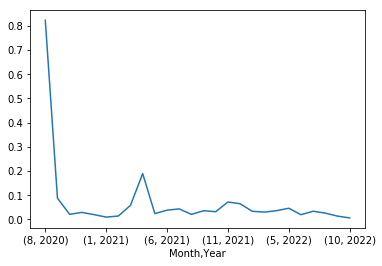

In [326]:
#Plotting

hrp_df = pd.DataFrame(hrp_list, columns=["Month","Year","Returns", "Volatility"])
hrp_df.set_index(['Month','Year'],inplace=True)
hrp_df['Volatility'].plot(x='Volatility')

##  Markowitz (for entire data)

In [25]:
# Returns and Cov Matrix

returns = new_data.mean()

cov_matrix = new_data.cov()

# data.apply(gmean)
#geomtric means cannot be applied or negative numbers/zeros. In that case need log returns instead of pct_change for prices


,BTC,ETH
Date,,
2019-01-02,NaN,NaN
2019-01-03,-0.027422,-0.038881
2019-01-04,0.005452,0.035872
2019-01-05,-0.003252,0.006812
2019-01-06,0.058447,0.013451
...,...,...
2021-12-28,-0.062151,-0.060401
2021-12-29,-0.024336,-0.046408
2021-12-30,0.015668,0.023242


In [27]:
# Weights for n number of coins
random.seed(0)
weights = np.random.random(2)
weights /= weights.sum()

#Define number of portfolios (Assuming 100)

n_port =100


In [28]:
#Expected Portfolio Returns

port_rtrn = returns.dot(weights)*100


In [30]:
# Markovitz Model

#@ operator - shorthand for np.matmul (matrix multiplication)
port_var = np.transpose(weights)@cov_matrix@weights
port_vol = np.sqrt(port_var)*np.sqrt(252)


## Monthly Markovitz

In [32]:
marko_list = []
vol = 1

for i in range(0,len(df)):
       
    dataset= df[i]
    month= dataset.Month.unique()[0]
    year= dataset.Year.unique()[0]
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataset= df[i].drop(columns=['Month','Year']).dropna()
    dataset.set_index('Date', inplace=True)

    vol = 1
    for j in range(0,n_port):
        
        random.seed(0)
        weights1 = np.random.random(2)
        weights1 /= weights1.sum()
        portrtrn = returns.dot(weights1)*100
        portvar = np.transpose(weights1)@cov_matrix@weights1
        portvol = np.sqrt(portvar)*np.sqrt(252)*100
        if portvol< vol:
            vol = portvol
        else:
            continue
    marko_list.append([month,year,portrtrn,vol])


C:\Users\Nilakshi Mondal\AppData\Local\Temp\ipykernel_36816\3613977431.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Nilakshi Mondal\AppData\Local\Temp\ipykernel_36816\3613977431.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Nilakshi Mondal\AppData\Local\Temp\ipykernel_36816\3613977431.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

<AxesSubplot: xlabel='Month,Year'>

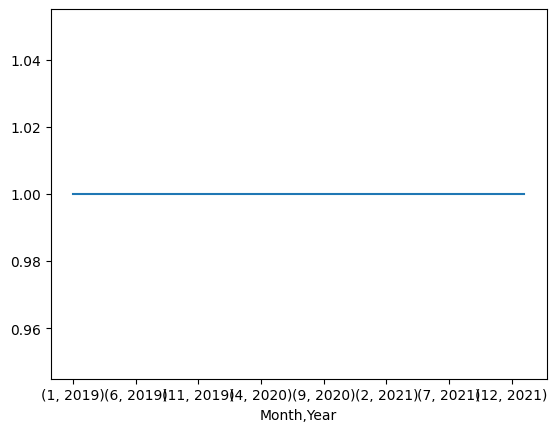

In [33]:
#Plotting

marko_df = pd.DataFrame(marko_list, columns=["Month","Year","Returns", "Volatility"])
marko_df.set_index(['Month','Year'],inplace=True)
marko_df['Volatility'].plot(x='Volatility')

## Actual Vol (Entire Data)

In [35]:
act_vol =new_data.std().std(axis=0)


## Actual Vol Monthly

In [37]:
mon_vol= log_returns.groupby(['Year','Month']).std().std(axis=1)


C:\Users\Nilakshi Mondal\AppData\Local\Temp\ipykernel_36816\1035967473.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mon_vol= log_returns.groupby(['Year','Month']).std().std(axis=1)


## Plot ALL

NameError: name 'hrp_df' is not defined

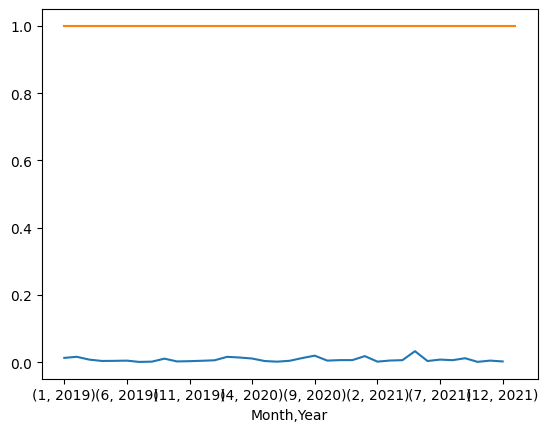

In [40]:
#Monthly Volatility

fig,ax= plt.subplots()
mon_vol.dropna().plot(label='Actual')
marko_df['Volatility'].plot(x='Volatility',label='Markowitz')
hrp_df['Volatility'].plot(x='Volatility',label='HRP')
ax.legend()

C:\Users\Nilakshi Mondal\AppData\Local\Temp\ipykernel_36816\3560667793.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mon_rtrn = log_returns.groupby(['Year','Month']).mean().mean(axis=1)


NameError: name 'hrp_df' is not defined

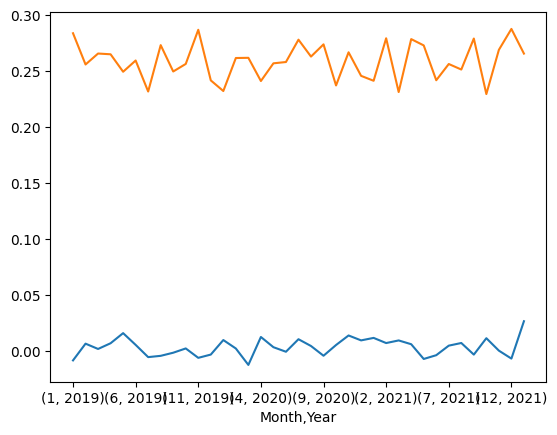

In [41]:
#Monthly Returns

mon_rtrn = log_returns.groupby(['Year','Month']).mean().mean(axis=1)

fig,ax= plt.subplots()
mon_rtrn.dropna().plot(label='Actual')
marko_df['Returns'].plot(x='Returns',label='Markowitz')
hrp_df['Returns'].plot(x='Returns',label='HRP')
ax.legend()

## Performance Measure


In [42]:
#Volatility

#Markowitz
mv =mean_squared_error(mon_vol.dropna(),marko_df['Volatility'])

#HRP
hv =mean_squared_error(mon_vol.dropna(),hrp_df['Volatility'])

ValueError: Found input variables with inconsistent numbers of samples: [36, 37]

In [43]:
#Returns

#Markowitz
mr =mean_squared_error(mon_rtrn,marko_df['Returns'])

#HRP
hr =mean_squared_error(mon_rtrn,hrp_df['Returns'])

NameError: name 'hrp_df' is not defined

In [44]:
final_df = pd.DataFrame([[port_rtrn,hrp_rtrn],[port_vol,hrp_vol]], index=['Returns','Volatility'],columns=['Markowitz','Hierarchial Risk Parity'])

In [45]:
#Results for Entire Data
final_df

,Markowitz,Hierarchial Risk Parity
Returns,0.257051,63.448161
Volatility,0.671206,65.781556


In [46]:
perf_df = pd.DataFrame([[mr,hr],[mv,hv]], index=['Returns MSE','Volatility MSE'],columns=['Markowitz','Hierarchial Risk Parity'])

NameError: name 'hr' is not defined

In [47]:
#Performance Measure
perf_df

NameError: name 'perf_df' is not defined